In [1]:
import git
import numpy as np
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# load data from compare-models notebook
episodes = pd.read_pickle("episodes.pkl")

episodes = episodes.assign(
    protocol=pd.Categorical(
        episodes.protocol,
        categories=sorted(set(episodes.protocol), key=lambda x: x != "nakamoto"),
    )
)
episodes = episodes.assign(
    kind=pd.Categorical(episodes.kind, categories=["trained", "hard-coded"])
)
columns = list(episodes.columns)
columns.remove("family")
columns.insert(1, "family")
episodes = episodes[columns]
episodes = episodes.assign(
    episode_relrew=lambda d: d.episode_reward_attacker
    / (d.episode_reward_attacker + d.episode_reward_defender),
    episode_rpp=lambda d: d.episode_reward_attacker / d.episode_progress,
)
list(episodes.columns)

['protocol',
 'family',
 'k',
 'reward',
 'subblock_selection',
 'alpha',
 'gamma',
 'batch',
 'learning_rate',
 'ent_coef',
 'shape',
 'policy',
 'path',
 'kind',
 'reuse',
 'reused',
 'episode',
 'episode_reward_attacker',
 'episode_reward_defender',
 'episode_progress',
 'episode_chain_time',
 'episode_sim_time',
 'episode_n_steps',
 'episode_n_activations',
 'episode_relrew',
 'episode_rpp']

In [3]:
dict(
    alpha=episodes.alpha.drop_duplicates().sort_values().tolist(),
    gamma=episodes.gamma.drop_duplicates().sort_values().tolist(),
    kind=episodes.kind.drop_duplicates().sort_values().tolist(),
    reuse=episodes.reuse.drop_duplicates().sort_values().tolist(),
    n_episodes=len(episodes.episode.drop_duplicates()),
    n_models=len(episodes.path.drop_duplicates()) - 1,  # minus 1 for NaN
)

{'alpha': [0.25, 0.3, 0.35, 0.4, 0.45],
 'gamma': [0.05, 0.5, 0.95],
 'kind': ['trained', 'hard-coded'],
 'reuse': ['-', 'gamma05', 'gamma50', 'gamma95'],
 'n_episodes': 100,
 'n_models': 144}

In [4]:
setting_key = [
    "protocol",
    "family",
    "k",
    "reward",
    "subblock_selection",
    "alpha",
    "gamma",
]
settings = (
    episodes[setting_key]
    .drop_duplicates()
    .sort_values(setting_key)
    .reset_index(drop=True)
)
settings

,protocol,family,k,reward,subblock_selection,alpha,gamma
0,stree-8-discount,stree,8,discount,heuristic,0.25,0.05
1,stree-8-discount,stree,8,discount,heuristic,0.25,0.50
2,stree-8-discount,stree,8,discount,heuristic,0.25,0.95
3,stree-8-discount,stree,8,discount,heuristic,0.30,0.05
4,stree-8-discount,stree,8,discount,heuristic,0.30,0.50
5,stree-8-discount,stree,8,discount,heuristic,0.30,0.95
6,stree-8-discount,stree,8,discount,heuristic,0.35,0.05
7,stree-8-discount,stree,8,discount,heuristic,0.35,0.50
8,stree-8-discount,stree,8,discount,heuristic,0.35,0.95
9,stree-8-discount,stree,8,discount,heuristic,0.40,0.05


In [5]:
trained_episodes = (
    # episodes.query('kind == "trained" or (family in ["nakamoto", "tailstorm"])')
    episodes.sort_values(setting_key).reset_index(drop=True)
)
trained_episodes[setting_key + ["policy"]]

,protocol,family,k,reward,subblock_selection,alpha,gamma,policy
0,stree-8-discount,stree,8,discount,heuristic,0.25,0.05,ppo-145k158w-best
1,stree-8-discount,stree,8,discount,heuristic,0.25,0.05,ppo-n6b7hprm-best
2,stree-8-discount,stree,8,discount,heuristic,0.25,0.05,ppo-145k158w-last
3,stree-8-discount,stree,8,discount,heuristic,0.25,0.05,ppo-n6b7hprm-last
4,stree-8-discount,stree,8,discount,heuristic,0.25,0.05,ppo-5zy0dbfn-best
...,...,...,...,...,...,...,...,...
61195,sdag-8-discount,sdag,8,discount,heuristic,0.45,0.95,minor-delay
61196,sdag-8-discount,sdag,8,discount,heuristic,0.45,0.95,override-catchup
61197,sdag-8-discount,sdag,8,discount,heuristic,0.45,0.95,override-block
61198,sdag-8-discount,sdag,8,discount,heuristic,0.45,0.95,release-block


In [6]:
model_key = setting_key + ["policy", "kind"]
models = (
    trained_episodes.groupby(model_key, observed=True)
    .agg(
        n=("episode", len),
        relrew_mean=("episode_relrew", np.mean),
        relrew_std=("episode_relrew", np.std),
        rpp_mean=("episode_rpp", np.mean),
        rpp_std=("episode_rpp", np.std),
    )
    .reset_index()
)
models

/tmp/ipykernel_15801/724410382.py:3: FutureWarning: The provided callable <function mean at 0x7f76b4472310> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  trained_episodes.groupby(model_key, observed=True)
/tmp/ipykernel_15801/724410382.py:3: FutureWarning: The provided callable <function std at 0x7f76b4472430> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  trained_episodes.groupby(model_key, observed=True)


,protocol,family,k,reward,subblock_selection,alpha,gamma,policy,kind,n,relrew_mean,relrew_std,rpp_mean,rpp_std
0,stree-8-discount,stree,8,discount,heuristic,0.25,0.05,honest,hard-coded,100,0.247915,0.009921,0.247915,0.009921
1,stree-8-discount,stree,8,discount,heuristic,0.25,0.05,minor-delay,hard-coded,100,0.081808,0.015028,0.079204,0.014169
2,stree-8-discount,stree,8,discount,heuristic,0.25,0.05,override-block,hard-coded,100,0.085315,0.014833,0.082451,0.013923
3,stree-8-discount,stree,8,discount,heuristic,0.25,0.05,override-catchup,hard-coded,100,0.051607,0.008574,0.050309,0.008171
4,stree-8-discount,stree,8,discount,heuristic,0.25,0.05,ppo-145k158w-best,trained,100,0.248882,0.009214,0.248882,0.009214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
607,sdag-8-discount,sdag,8,discount,heuristic,0.45,0.95,ppo-edrlpjs2-best,trained,100,0.481607,0.024682,0.467379,0.024029
608,sdag-8-discount,sdag,8,discount,heuristic,0.45,0.95,ppo-edrlpjs2-last,trained,100,0.370493,0.043644,0.346457,0.041000
609,sdag-8-discount,sdag,8,discount,heuristic,0.45,0.95,ppo-vw8609oz-best,trained,100,0.470488,0.034146,0.456392,0.033430
610,sdag-8-discount,sdag,8,discount,heuristic,0.45,0.95,ppo-vw8609oz-last,trained,100,0.094069,0.040549,0.091725,0.039232


In [7]:
best_models = models.loc[
    models.groupby(setting_key + ["kind"], observed=True).rpp_mean.idxmax()
]
best_models_episodes = pd.merge(
    best_models[model_key], episodes, on=model_key, how="left"
)

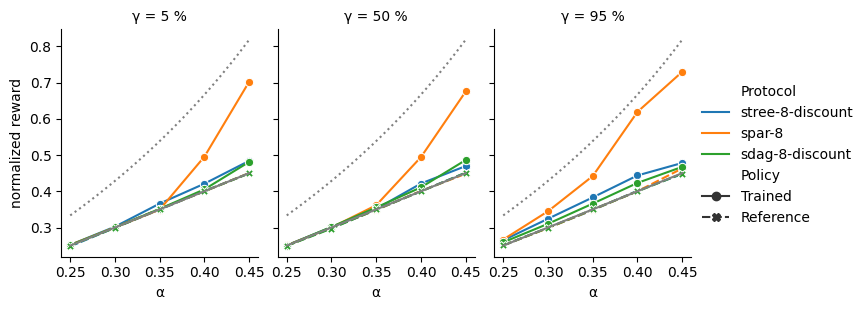

In [8]:
# Some renaming for the paper
def humProtocol(x):
    if x == "nakamoto":
        return "Bitcoin"
    if x == "tailstorm-8-discount":
        return "Tailstorm"
    if x == "tailstorm-8-constant":
        return "TS/const"
    if x == "bk-8":
        return "Bₖ"
    return x


def humPolicy(x):
    if x == "trained":
        return "Trained"
    if x == "hard-coded":
        return "Reference"
    return x


subset = best_models.copy()
subset["Protocol"] = subset.protocol.map(humProtocol)
subset.Protocol = pd.Categorical(
    subset.Protocol  # , categories=["Bitcoin", "TS/const", "Tailstorm", "Bₖ"]
)
subset["Policy"] = subset.kind.map(humPolicy)
subset.Policy = pd.Categorical(subset.Policy, categories=["Trained", "Reference"])
subset["γ"] = subset.gamma.map(lambda x: f"{x * 100:g} %")
subset["α"] = subset.alpha

fig = sns.relplot(
    kind="line",
    data=subset,
    y="rpp_mean",
    x="α",
    col="γ",
    hue="Protocol",
    style="Policy",
    markers=True,
    height=3.2,
    aspect=0.75,
)
fig.set(ylabel="normalized reward")
for ax in fig.axes.flatten():
    alpha = np.linspace(min(best_models.alpha), max(best_models.alpha), 20)
    ax.plot(alpha, alpha, linestyle="solid", color="gray")
    ax.plot(alpha, alpha / (1 - alpha), linestyle="dotted", color="gray")
    # ax.set_xticks(subset.alpha.drop_duplicates(), labels=subset.alpha.drop_duplicates(), rotation=30)
    ax.set_xticks(subset.alpha.drop_duplicates())


fig.savefig(
    "reward_per_progress_rl.png",
    dpi=600,
    bbox_inches="tight",
    transparent=True,
    pad_inches=0,
)

In [9]:
# Build and export wide CSV table for pgfplots
def texProtocol(x):
    if x.family == "nakamoto":
        return "seq"
    if x.family == "tailstorm":
        return f"ts{x.k}{x.reward[0]}"
    if x.family in ["spar", "sdag", "stree"]:
        return f"{x.family[1:]}{x.k}{x.reward[0]}"
    if x.family == "bk":
        return f"bk{x.k}"
    assert False


def texPolicy(x):
    if x == "trained":
        return "rl"
    if x == "hard-coded":
        return "hc"
    assert False


subset = best_models.copy()
subset["protocol"] = subset.apply(texProtocol, axis=1)
subset["policy"] = subset.kind.map(texPolicy)
subset["gamma"] = subset.gamma.map(lambda x: f"gamma{int(x * 100):02d}")
wide = subset.pivot(
    index="alpha", columns=["gamma", "protocol", "policy"], values="rpp_mean"
)
wide.columns = ["_".join(col) for col in wide.columns.values]
wide.to_csv("rl-results.csv")
wide

,gamma05_tree8d_rl,gamma05_tree8d_hc,gamma50_tree8d_rl,gamma50_tree8d_hc,gamma95_tree8d_rl,gamma95_tree8d_hc,gamma05_par8c_rl,gamma05_par8c_hc,gamma50_par8c_rl,gamma50_par8c_hc,gamma95_par8c_rl,gamma95_par8c_hc,gamma05_dag8d_rl,gamma05_dag8d_hc,gamma50_dag8d_rl,gamma50_dag8d_hc,gamma95_dag8d_rl,gamma95_dag8d_hc
alpha,,,,,,,,,,,,,,,,,,
0.25,0.252012,0.247915,0.250898,0.249600,0.264746,0.251016,0.251984,0.250830,0.250649,0.249722,0.266803,0.250732,0.251416,0.250015,0.249872,0.249346,0.259177,0.250493
0.30,0.302314,0.299328,0.301006,0.298664,0.324117,0.299136,0.300106,0.300625,0.300022,0.299580,0.344748,0.298359,0.300202,0.299346,0.301794,0.297046,0.310229,0.299033
0.35,0.366081,0.349365,0.351401,0.348540,0.383002,0.347881,0.349456,0.350894,0.361516,0.348633,0.441913,0.348930,0.351517,0.350879,0.355320,0.349756,0.365880,0.349785
0.40,0.420989,0.400771,0.421358,0.400269,0.443582,0.401496,0.495727,0.399849,0.494368,0.400832,0.619078,0.399995,0.405344,0.400107,0.410755,0.399478,0.422990,0.399687
0.45,0.484066,0.449846,0.469520,0.451279,0.478130,0.447664,0.702562,0.450210,0.675255,0.448289,0.729597,0.463002,0.481151,0.449346,0.486215,0.451230,0.467379,0.448740
